In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
from scipy import sparse 
import itertools

import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
from umap import UMAP

from py_pcha import PCHA
from sklearn.cluster import KMeans

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu



In [2]:
def plot_pcs(res, npc, hue, palette=None):
    fig, axs = plt.subplots(npc-1,npc-1,figsize=(6*(npc-1),5*(npc-1)))
    for i, j in itertools.combinations(range(npc), 2):
        legend = False
        if (i,j) == (0,1): legend=True

        x, y = f"PC{j+1}", f"PC{i+1}"
        ax = axs[i,j-1]
        
        if palette is not None:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            hue_order=list(palette.keys()),
                            palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        else:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            # hue_order=list(palette.keys()),
                            # palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        sns.despine(ax=ax)
    axs[0,0].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

    for i, j in itertools.product(range(npc-1), range(npc-1)):
        if j<i:
            ax = axs[i,j]
            ax.axis('off')

    plt.show()

In [3]:
outdir     = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results"
outdir_fig = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/figures"

In [4]:
def norm_pca(adata, return_pcs=False):
    
    np.random.seed(0)
    zlognorm = zscore(np.array(adata.layers['lognorm'].todense()), axis=0)
    pca = PCA(n_components=50)
    
    zlognorm = np.nan_to_num(zlognorm, 0)
    pcs = pca.fit_transform(zlognorm)
    if return_pcs:
        return pca, pcs
    else:
        return pca

In [5]:
def pipe_pca(ftrs):
    
    np.random.seed(0)
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(ftrs)
    return pca, pcs


In [6]:
# 3 clusters
np.random.seed(0)

datasets = []
pc_sets = []

ng = 50
n = 200
eps_list = [1,2,4,8]
orig_types  = np.repeat([0,1,2],n)
orig_colors = np.repeat(['C0','C1','C2'],n)


means = 4*np.random.rand(3, ng)

for eps in eps_list:
    ftrs_a = eps*np.random.randn(n, ng) + means[0]
    ftrs_b = eps*np.random.randn(n, ng) + means[1] #10*np.ones(ng) # [10, -5]
    ftrs_c = eps*np.random.randn(n, ng) + means[2] #20*np.ones(ng) # [20, 0]
    data = np.vstack([ftrs_a, ftrs_b, ftrs_c])
    pca, pcs = pipe_pca(data)
    
    datasets.append(data)
    pc_sets.append(pcs)



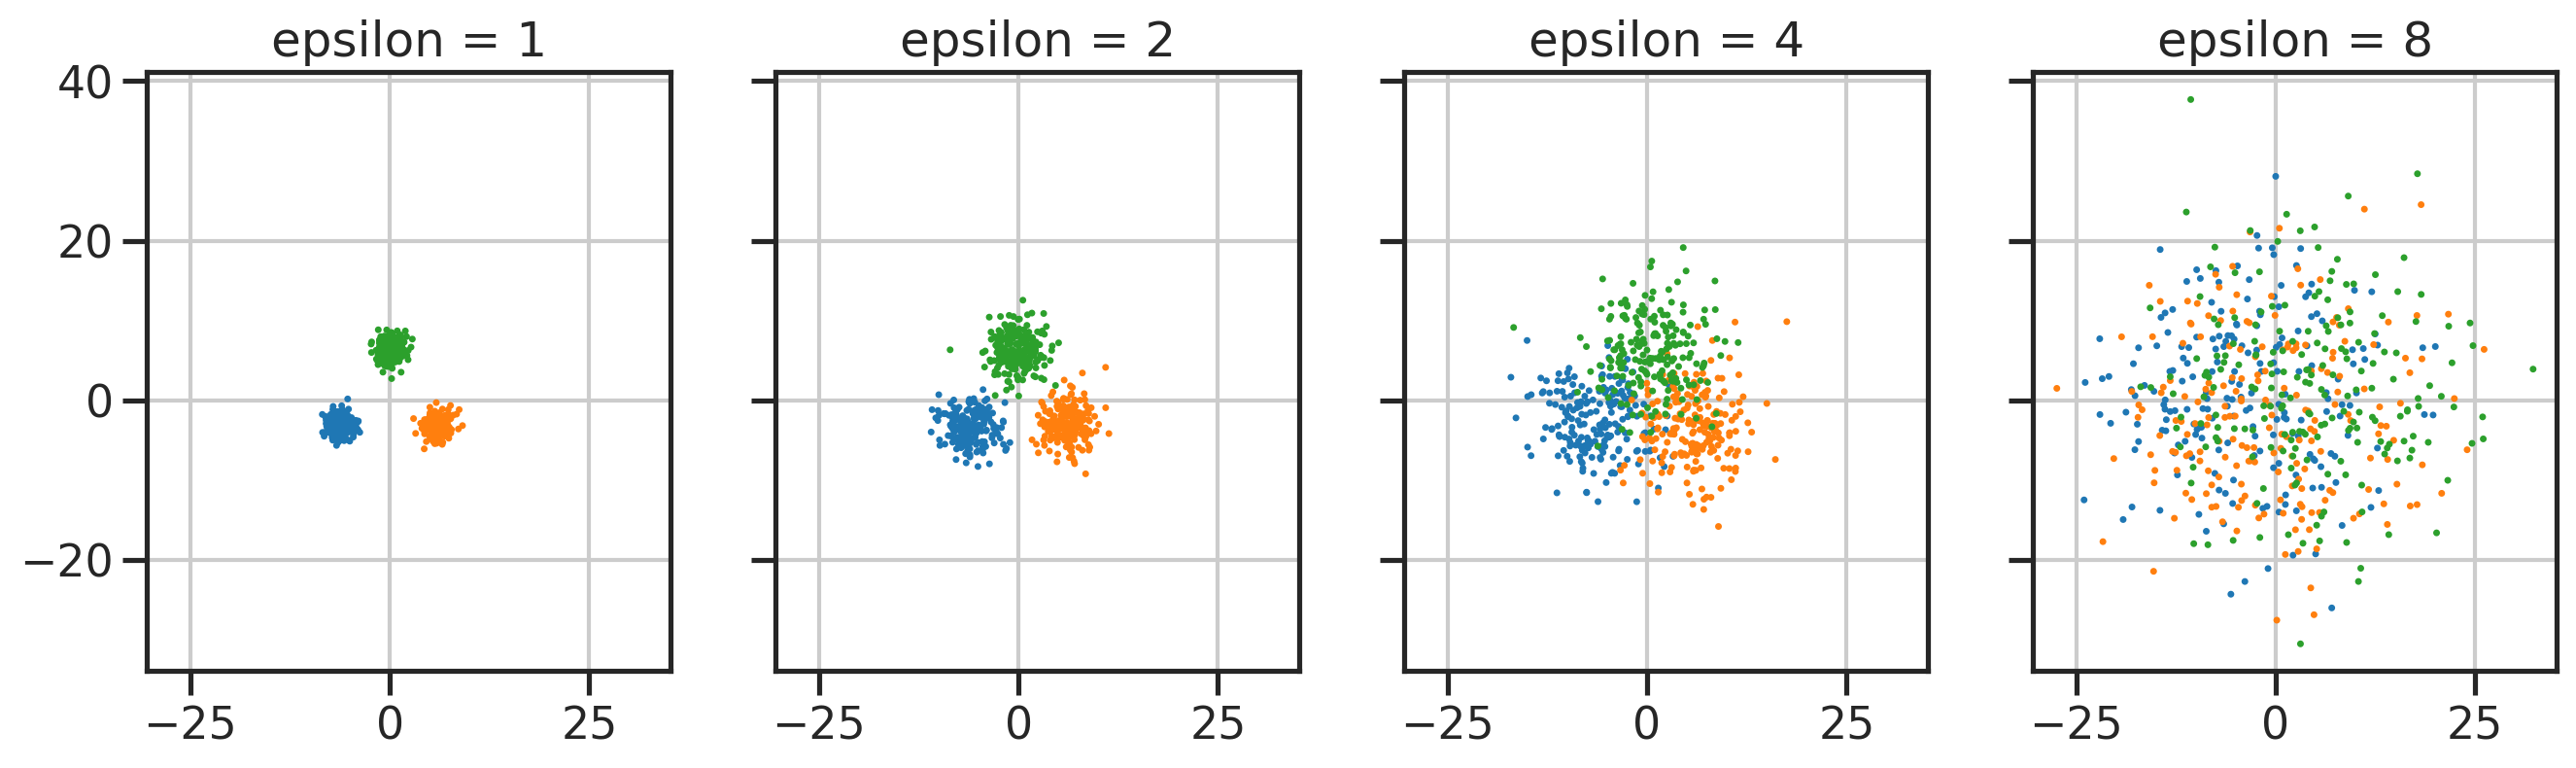

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(4*4,1*4), sharex=True, sharey=True)
for ax, eps, pcs in zip(axs, eps_list, pc_sets):
    ax.scatter(pcs[:,0], pcs[:,1], c=orig_colors, s=1)
    ax.set_aspect('equal')
    ax.set_title(f'epsilon = {eps}')
plt.show()

In [8]:
pcs = pc_sets[0]
X = pcs.T
X.shape

(2, 600)

In [9]:
XC, S, C, SSE, varexpl = PCHA(X, noc=3, delta=0)
XC = np.array(XC)
print(XC.shape, S.shape, C.shape, SSE.shape, varexpl.shape)

(2, 3) (3, 600) (600, 3) () ()


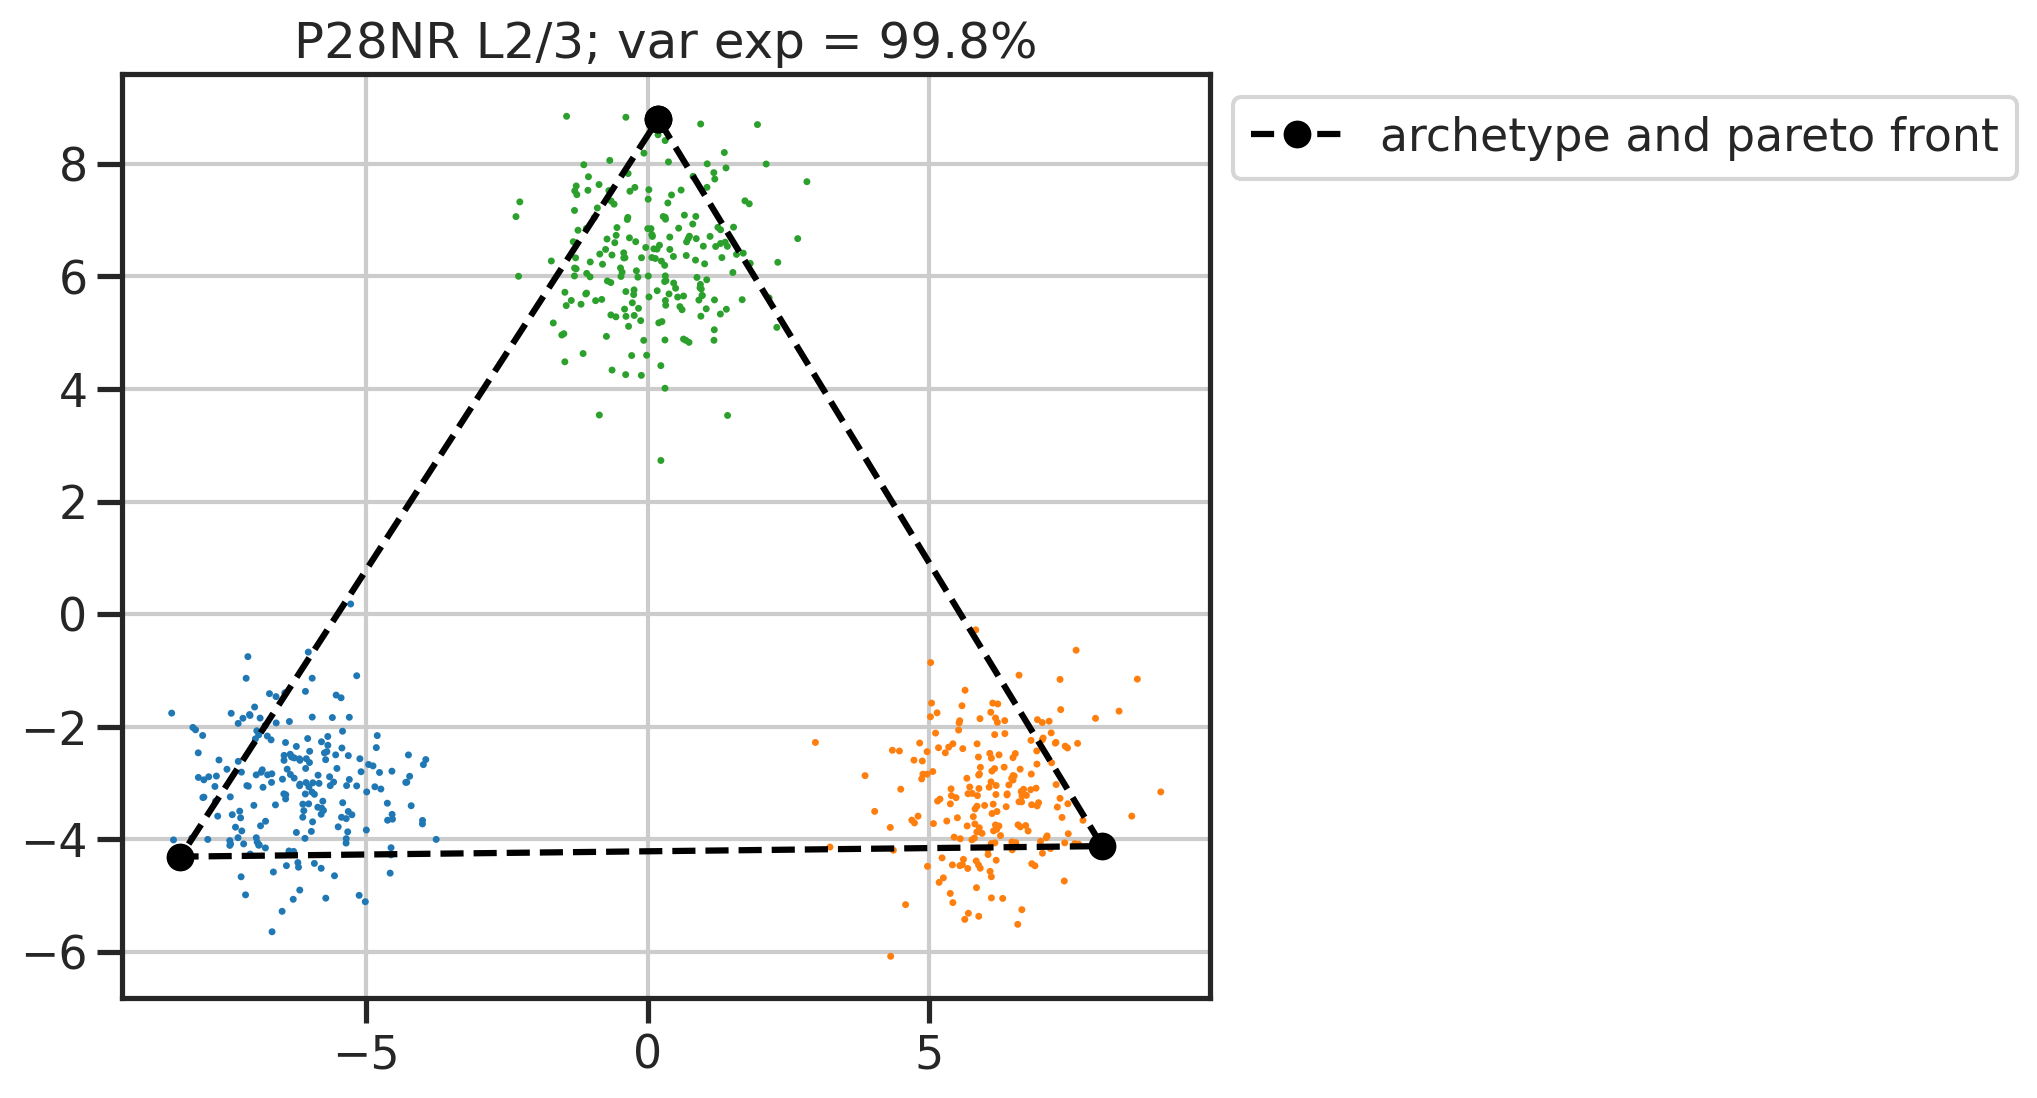

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pcs[:,0], pcs[:,1], c=orig_colors, s=1)

ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--ok', label='archetype and pareto front')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title(f'P28NR L2/3; var exp = {100*varexpl:.1f}%')
ax.set_aspect('equal')
plt.show()

# shuffle

In [11]:
def shuff_genes(mat, seed=0):
    """
    shuffle each column independently
    
    if cell by gene as input; it will shuffle each gene independently across cells
    """
    rng = np.random.default_rng(seed=seed)
    mat_shuff = rng.permuted(mat, axis=0)
    return mat_shuff


In [12]:
def get_X(zlognorm):
    """cell by gene as input
    """
    pcs = PCA(n_components=2).fit_transform(zlognorm)
    return pcs.T

In [13]:
def wrap_pcha(X, noc=3, delta=0, **kwargs):
    """
    """
    XC, S, C, SSE, varexpl = PCHA(X, noc=noc, delta=delta, **kwargs)
    return np.array(XC), S, C, SSE, varexpl

In [14]:
def plot_archetype(ax, X, XC, varexpl, c=None):
    """
    """
    ax.scatter(X[0], X[1], c=c, s=2)
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--ok', 
            label=f'archetype\nvar expl = {100*varexpl:.1f}%')
    return ax 

def plot_archetype_only(ax, XC, fmt='--o', color='k', **kwargs):
    """
    """
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], fmt, color=color, **kwargs)

In [15]:
def downsample_X(X, p=0.8):
    """
    """
    return X[:,np.random.rand(X.shape[1])<p]

In [16]:
nrepeats = 2
data_id = 3
pcs = pc_sets[data_id]
data = datasets[data_id]

types = KMeans(n_clusters=3).fit_predict(pcs)
type_colorvec = np.array([f'C{i}' for i in types])

/u/home/f/f7xiesnm/.conda/envs/napari/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
# orig
X = pcs.T
XC, S, C, SSE, varexpl = wrap_pcha(X, noc=3, delta=0)

# repeat 
res_XC_sub = []
for i in range(nrepeats):
    X_sub = downsample_X(X, p=0.8)
    XC_sub, _, _, _, _ = wrap_pcha(X_sub, noc=3, delta=0)
    res_XC_sub.append(XC_sub)

In [18]:
# shuff each gene across cells independently
data_shuff = shuff_genes(data)
X_shuff = get_X(data_shuff) # .T
XC_shuff, S_shuff, C_shuff, SSE_shuff, varexpl_shuff = wrap_pcha(X_shuff, noc=3, delta=0)

# repeat 
res_XC_shuff_sub = []
for i in range(nrepeats):
    X_shuff_sub = downsample_X(X_shuff, p=0.8)
    XC_shuff, _, _, _, _ = wrap_pcha(X_shuff_sub, noc=3, delta=0)
    res_XC_shuff_sub.append(XC_shuff)

In [19]:
# shuff each gene across cells independently - internally for each type A,B,C
data_tshuff = data.copy()
idx, lbl = pd.factorize(types)
for i in range(len(lbl)):
    data_tshuff[idx==i] = shuff_genes(data[idx==i])

X_tshuff = get_X(data_tshuff) # .T
XC_tshuff, S_tshuff, C_tshuff, SSE_tshuff, varexpl_tshuff = wrap_pcha(X_tshuff, noc=3, delta=0)

# repeat 
res_XC_tshuff_sub = []
for i in range(nrepeats):
    X_tshuff_sub = downsample_X(X_tshuff, p=0.8)
    XC_tshuff, _, _, _, _ = wrap_pcha(X_tshuff_sub, noc=3, delta=0)
    res_XC_tshuff_sub.append(XC_tshuff)

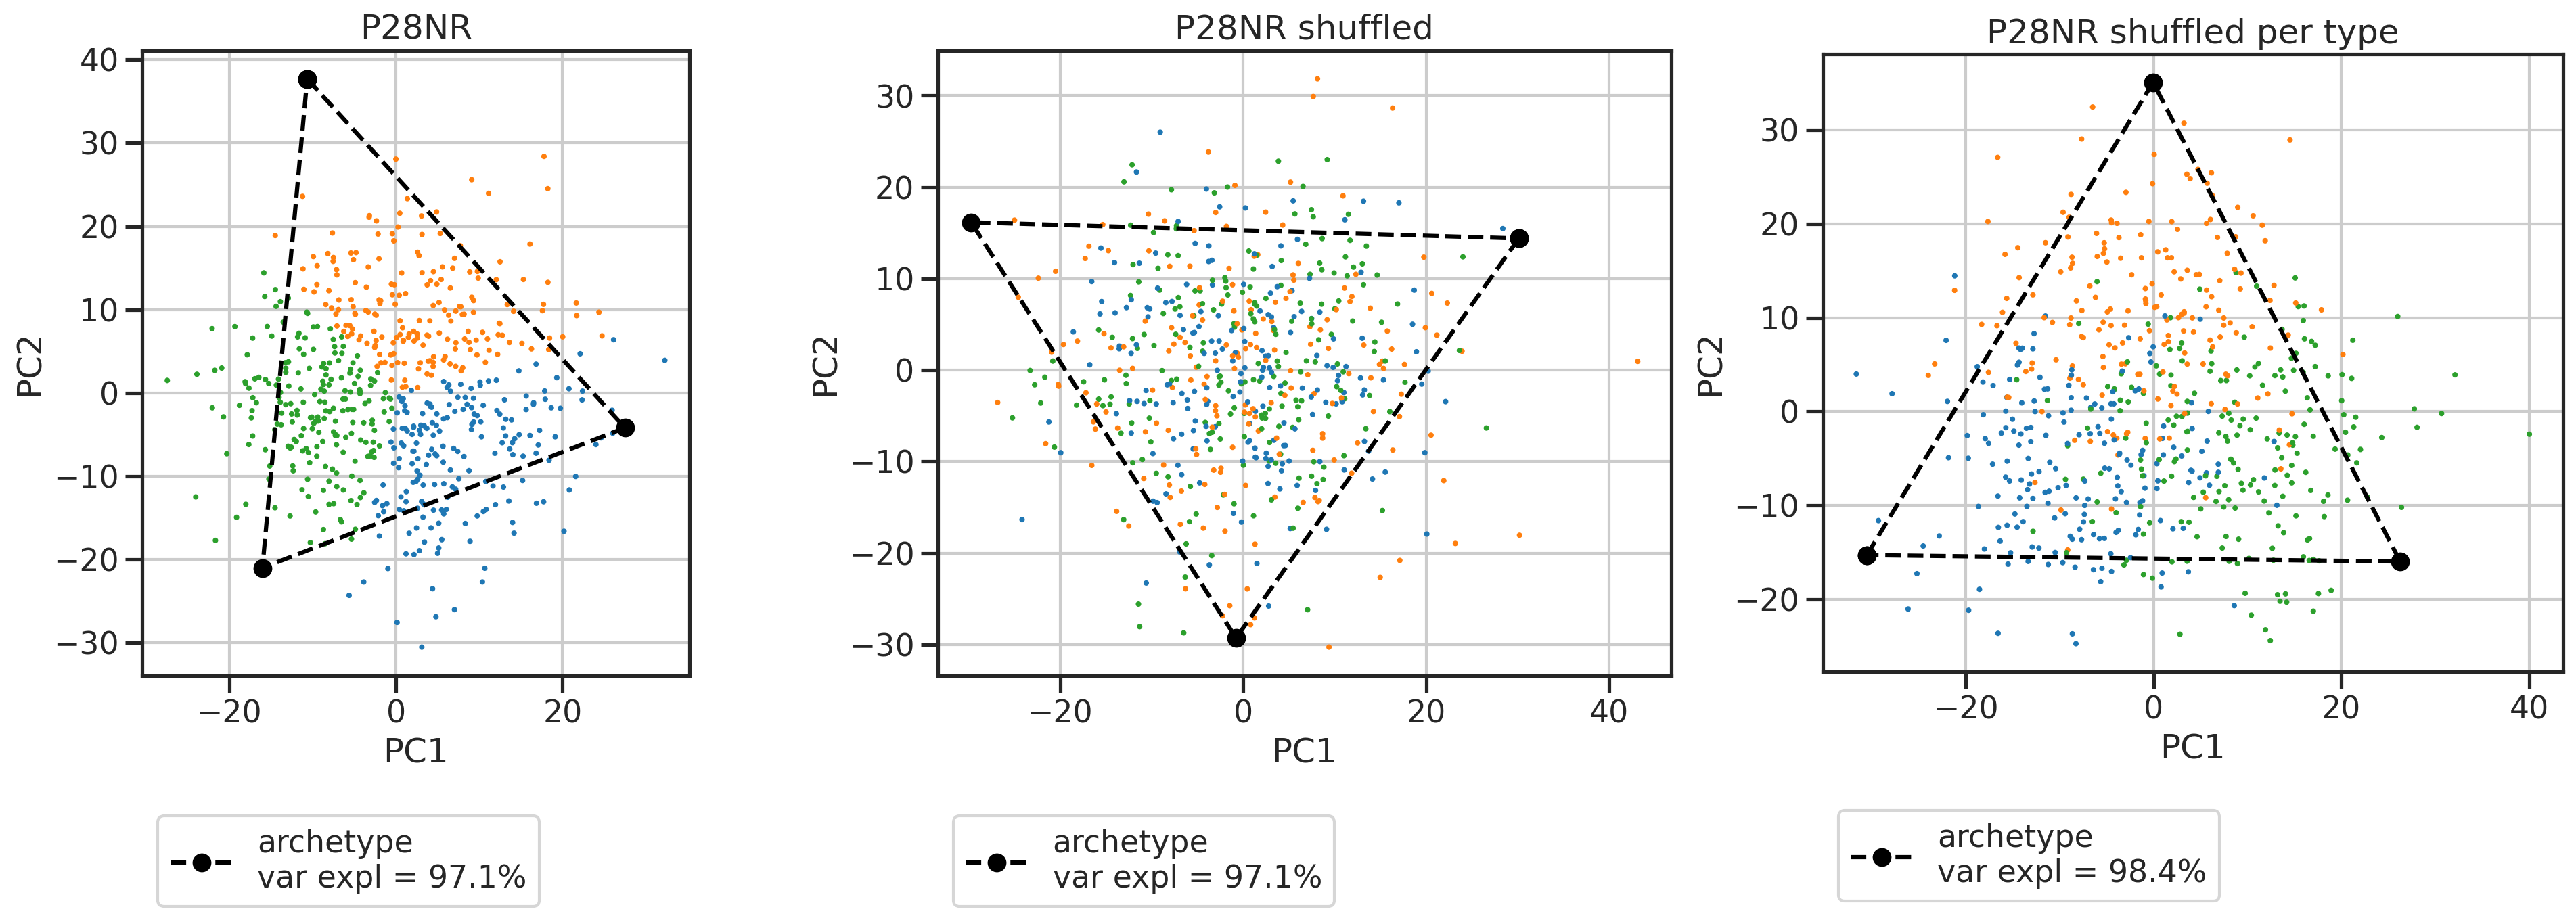

In [20]:
fig, axs = plt.subplots(1,3,figsize=(8*3,6))
ax = axs[0]
plot_archetype(ax, X, XC, varexpl, c=type_colorvec)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('P28NR')

ax = axs[1]
plot_archetype(ax, X_shuff, XC_shuff, varexpl_shuff, c=type_colorvec)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('P28NR shuffled')

ax = axs[2]
plot_archetype(ax, X_tshuff, XC_tshuff, varexpl_tshuff, c=type_colorvec)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('P28NR shuffled per type')
plt.show()

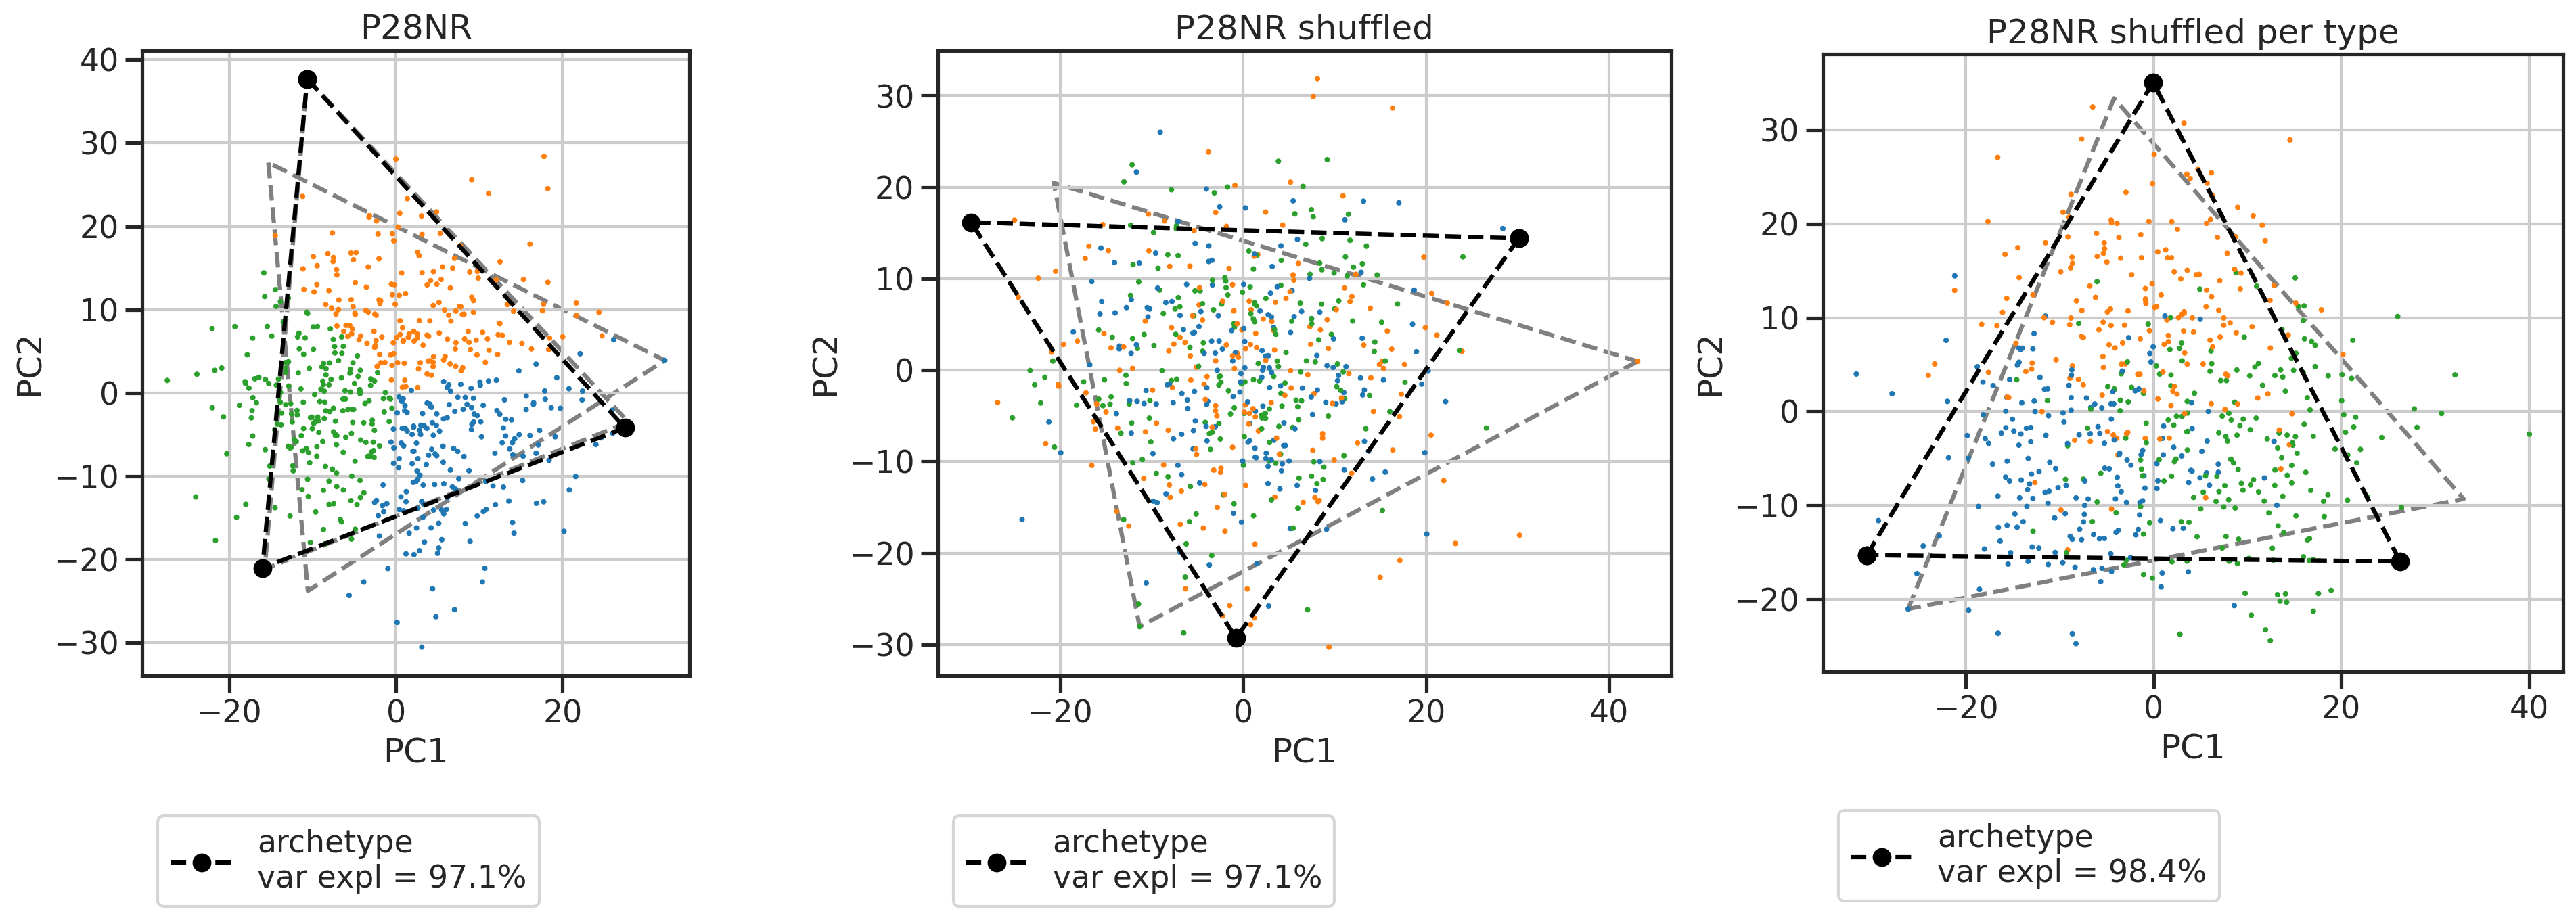

In [21]:
fig, axs = plt.subplots(1,3,figsize=(8*3,6))
ax = axs[0]
plot_archetype(ax, X, XC, varexpl, c=type_colorvec)
for i in range(nrepeats):
    plot_archetype_only(ax, res_XC_sub[i], 
                        fmt='--', color='gray', zorder=0)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_aspect('equal')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('P28NR')

ax = axs[1]
plot_archetype(ax, X_shuff, XC_shuff, varexpl_shuff, c=type_colorvec)
for i in range(nrepeats):
    plot_archetype_only(ax, res_XC_shuff_sub[i], 
                        fmt='--', color='gray', zorder=0)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_aspect('equal')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('P28NR shuffled')

ax = axs[2]
plot_archetype(ax, X_tshuff, XC_tshuff, varexpl_tshuff, c=type_colorvec)
for i in range(nrepeats):
    plot_archetype_only(ax, res_XC_tshuff_sub[i], 
                        fmt='--', color='gray', zorder=0)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_aspect('equal')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('P28NR shuffled per type')
plt.show()